**TP : La Fusion Multimodale**

Lors de ce TP, nous allons étudier la fuson multimodale au niveau de la décision  et par la suite au niveau des caractéristiques (early fusion)

Pour cela, vous avez à disposition une partie de la base de données AffectNet. AffectNet est une base qui contient presque 300.000 images réparties sur 8 classes (émotions).
Pou ce TP, nous utiliserons que 4 classes : anger, happu, neutral et surprise. 
chaque classe contient 1000 images.

Vous avez également une base de données de cartes de profondeur. Ces cartes representent les images d'AffectNet. Elles ont été synthétisées grâce à Depth Anything. 

In [202]:
# Bibliothéques
import numpy as np 
from matplotlib import pyplot as plt
import pandas as pd
import math
import os 
import seaborn as sns
import cv2

from keras.api.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from sklearn.metrics import confusion_matrix


***Créez une fonction appelée data_visualization(classes, data) qui visualise la distribution des données dans un dataset en traçant un graphique en barres. Cette fonction doit prendre comme arguments une liste de classes (correspondant aux catégories) et une liste contenant le nombre d'images par catégorie***

In [134]:
def data_visualization(data_path):

    classes = os.listdir(data_path)
    data_per_class = np.empty(len(classes))

    for i, cls in enumerate(classes) :
        data_per_class[i] = len(os.listdir(os.path.join(data_path, cls)))

    print(data_per_class)
    plt.bar(classes, height=data_per_class)

[1000. 1000. 1000. 1000.]


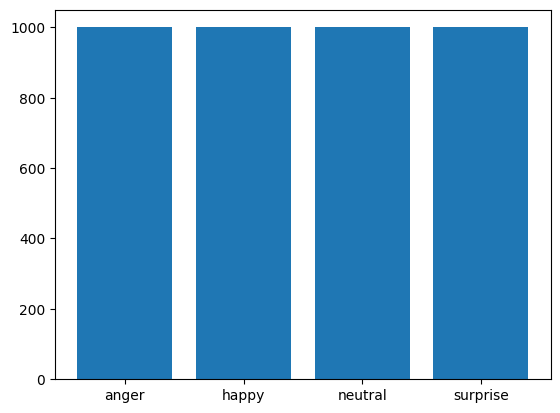

In [135]:
data_visualization(data_path='../datasets/tp6/depth')

**Écrivez une fonction load_data() qui :**

**1. Charge un dataset à partir d'un chemins de fichiers différents, en parcourant les sous-dossiers correspondant aux différentes classes d’émotions.**

**2. Charge les images de chaque classe, les redimensionne à une taille de 100x100, et les stocke dans une liste.**

**3. Encode les étiquettes des classes avec un encodeur LabelEncoder, puis effectue une conversion en encodage one-hot.**

**4. Visualise la distribution du nombre d'images par catégorie à l'aide d'une fonction data_visualization()**

**Retourne deux valeurs : les images et les étiquettes**

In [162]:
path = '../datasets/tp6/depth'
classes = os.listdir(path)
nb_imgs = 0
print(classes)
for cls in classes:
    nb_imgs += len(os.listdir(os.path.join(path, cls)))

data = []
for label in os.listdir(path):
    print(label)
    for img in os.listdir(os.path.join(path, label)):
        path_img = os.path.join(path, label, img)
        image = cv2.imread(path_img) 
        image = image / 255.0
        image = cv2.resize(image, (100, 100))
        data.append(image)



['anger', 'happy', 'neutral', 'surprise']
anger
happy
neutral
surprise


In [167]:
def load_data(path, shape=(100, 100)):
      
      nb_imgs = 0
      nb_classes = len(os.listdir(path))
      
      classes = os.listdir(path)
      for cls in classes:
            nb_imgs += len(os.listdir(os.path.join(path, cls)))
      
      data = []
      labels = []
      
      for label in os.listdir(path):
            for img in os.listdir(os.path.join(path, label)):
                  path_img = os.path.join(path, label, img)
                  image = cv2.imread(path_img) 
                  image = image / 255.0
                  image = cv2.resize(image, shape)
                  data.append(image)
                  labels.append(label)

      labels = LabelEncoder().fit_transform(np.array(labels))
      labels = to_categorical(labels)

      return np.array(data), labels

In [168]:
path_depth = '../datasets/tp6/depth'
path_rgb = '../datasets/tp6/rgb'

data_depth, labels_depth = load_data(path_depth)
data_rgb, labels_rgb = load_data(path_rgb)    

In [169]:
print(f'data_depth_shape : {data_depth.shape}, labels_depth : {labels_depth.shape}')
print(f'data_rgb_shape : {data_rgb.shape}, labels_rgb : {labels_rgb.shape}')

data_depth_shape : (4000, 100, 100, 3), labels_depth : (4000, 4)
data_rgb_shape : (4000, 100, 100, 3), labels_rgb : (4000, 4)


**Écrivez un code pour diviser un dataset en plusieurs sous-ensembles en suivant les étapes suivantes :**

**1. Divisez le dataset en deux sous-ensembles : un pour l'entraînement (70% des données) et un autre pour les tests (30% des données).**

**2. Prenez le sous-ensemble de test et divisez-le à nouveau en deux sous-ensembles égaux : un pour la validation (50%) et un autre pour les tests (50%).**

**3. Affichez les formes (dimensions) des jeux de données résultants : [X_train_rgb, X_valid_rgb, X_test_rgb, y_train_rgb, y_valid_rgb, y_test_rgb] et [X_train_d, X_valid_d, X_test_d, y_train_d, y_valid_d, y_test_d].**

**Attention ! mettez shuffle = False afin d'avoir le même autre d'apparition des RGB et Depth**

In [170]:
ind = np.arange(len(data_depth))
np.random.shuffle(ind)

data_depth, labels_depth = data_depth[ind], labels_depth[ind]
data_rgb, labels_rgb = data_rgb[ind], labels_rgb[ind]

train_size = int(0.7 * len(data_depth))     
val_size = int(0.15 * len(data_depth))        
test_size = len(data_depth) - train_size - val_size  

X_depth_train, y_depth_train = data_depth[:train_size], labels_depth[:train_size]
X_depth_val, y_depth_val = data_depth[train_size:train_size + val_size], labels_depth[train_size:train_size + val_size]
X_depth_test, y_depth_test = data_depth[train_size + val_size:], labels_depth[train_size + val_size:]

X_rgb_train, y_rgb_train = data_rgb[:train_size], labels_rgb[:train_size]
X_rgb_val, y_rgb_val = data_rgb[train_size:train_size + val_size], labels_rgb[train_size:train_size + val_size]
X_rgb_test, y_rgb_test = data_rgb[train_size + val_size:], labels_rgb[train_size + val_size:]

In [175]:
print(y_depth_test[400])
cv2.imshow('', X_depth_test[400])
cv2.waitKey(0)
cv2.destroyAllWindows()

[1. 0. 0. 0.]


**Créez un dictionnaire mapping qui mappe les labels des émotions à leurs noms respectifs. Par exemple, 0 correspond à 'anger', 1 à 'contempt', etc.**

In [176]:
label_dict = {
    'anger': 0,
    'happy': 1,
    'neutral': 2,
    'surprise': 3 
}
label_dict_inv = {v: k for k, v in label_dict.items()}

**Préparer l'augmentation des données : Utilisez ImageDataGenerator pour créer un objet d'augmentation des données qui applique certaines transformations aux images d'entraînement. Les transformations doivent inclure :**

**- Une rotation aléatoire jusqu'à 15 degrés.**

**- Un zoom aléatoire jusqu'à 15%.**

**- Un ajustement de la luminosité dans une plage de (0.6, 1.2).**

**- Une transformation en cisaillement jusqu'à 15%.**

**- Un retournement horizontal aléatoire.**

**- Le mode de remplissage doit être défini à "nearest".**

In [180]:
trainAug = ImageDataGenerator(
    rotation_range=15,               
    zoom_range=0.15,                   
    shear_range=0.15,                 
    horizontal_flip=True,              
    fill_mode='nearest'                
)

train_gen_depth = trainAug.flow(X_depth_train, y_depth_train, batch_size=9)    
train_gen_rgb = trainAug.flow(X_rgb_train, y_rgb_train, batch_size=9)
images_depth_aug, labels_rgb_aug = next(train_gen_depth)    
images_rgb_aug, labels_depth_aug = next(train_gen_rgb)              

**Affichez 9 exemples d'images augmentées aléatoirement à partir de votre ensemble d'entraînement en utilisant trainAug.flow() et affichez chaque image avec son label d'émotion associé.**

(-0.5, 99.5, 99.5, -0.5)

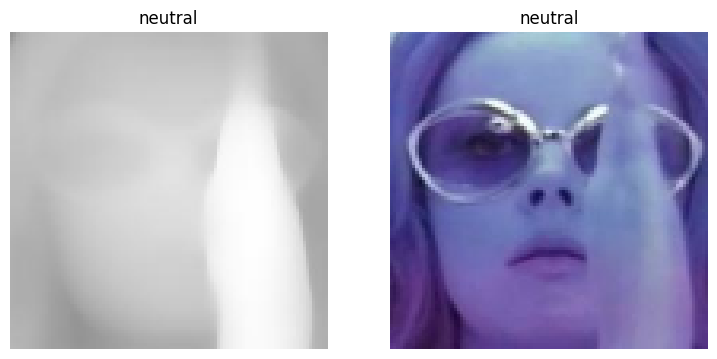

In [197]:
ind = 10
plt.figure(figsize=(9, 6))
plt.subplot(121)
plt.imshow(X_depth_train[ind]), plt.title(label_dict_inv[np.argmax(y_depth_train[ind])])
plt.axis('off')
plt.subplot(122)
plt.imshow(X_rgb_train[ind]), plt.title(label_dict_inv[np.argmax(y_rgb_train[ind])])
plt.axis('off')

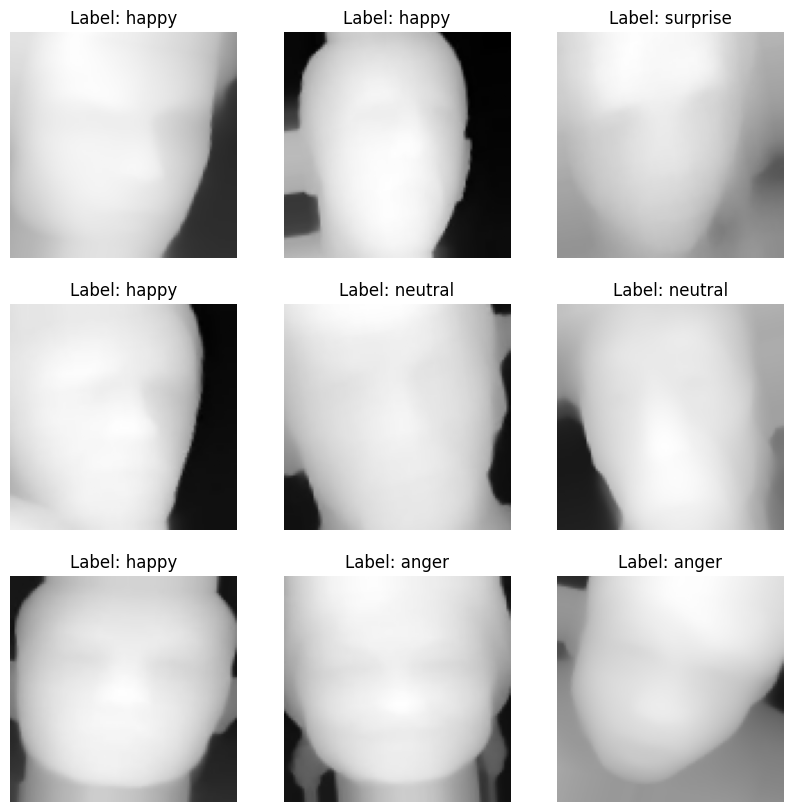

In [187]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_depth_aug[i])  
    plt.title(f"Label: {label_dict_inv[np.argmax(labels_depth_aug[i])]}")  
    plt.axis('off')  
plt.show()

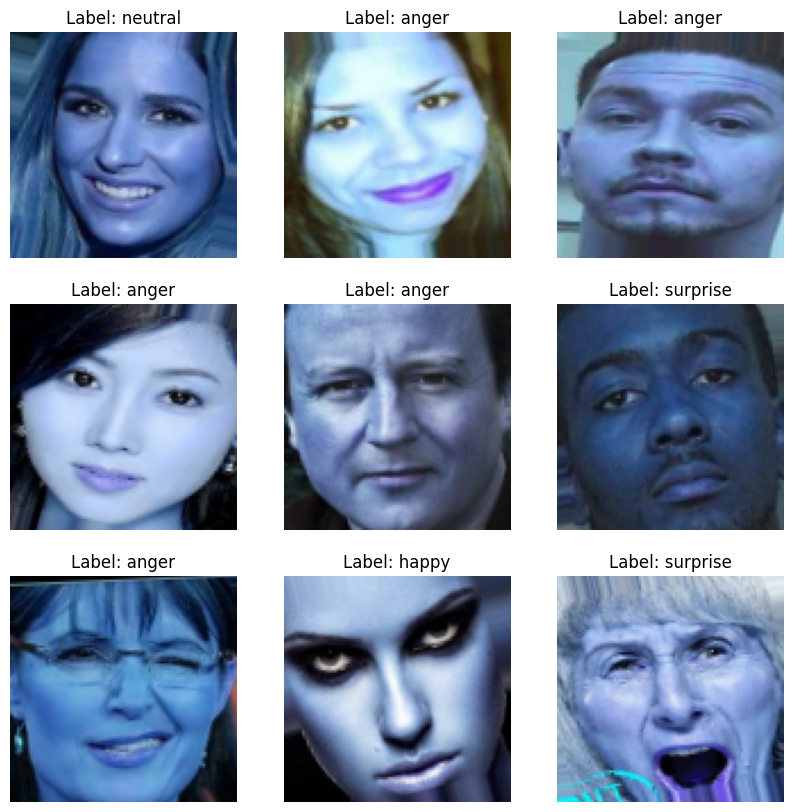

In [188]:
plt.figure(figsize=(10, 10))

for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images_rgb_aug[i])  
    plt.title(f"Label: {label_dict_inv[np.argmax(labels_rgb_aug[i])]}")  
    plt.axis('off')  
plt.show()

**late Fusion : Écrivez une fonction build_model() qui construit un model avec CNN(EfficientNet / VGG16 / VGG19) pré-entrainé sur ImageNet. N'oubliez pas de mettre classes=None. 
Ce modèle sera connecter à un Dense de 256, un BatchNormalization et un Dropout de 0.2. 
Duppliquez cette architecture en prenant soit le même CNNN ou bien un autre.**

In [185]:
from keras.api.layers import Input, Dense, GlobalAveragePooling2D, BatchNormalization, Dropout, Average
from keras.api.models import Model



def build_model():
    input_shape = (100, 100, 3)

    effnet = tf.keras.applications.efficientnet_v2.EfficientNetV2S(input_shape=input_shape, include_top=False, weights="imagenet")
    rgb = Input(shape=input_shape)
    x = effnet(rgb)
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    vgg = tf.keras.applications.VGG16(input_shape=input_shape, include_top=False, weights="imagenet")
    depth = Input(shape=input_shape)
    y = vgg(depth)
    y = GlobalAveragePooling2D()(y)
    y = Dense(256, activation='relu')(y)
    y = BatchNormalization()(y)
    y = Dropout(0.2)(y)

    z = Average(name='average_layer')([x, y])
    output = Dense(4, activation='softmax')(z)

    model = Model(inputs=[rgb, depth], outputs=output)

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = build_model()
model.summary()
    

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_25      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_27      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-s    │ (None, 4, 4,      │ 20,331,360 │ input_layer_25[0… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_27[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ efficientnetv2-s… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_14 (Dense)    │ (None, 256)       │    327,936 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_15 (Dense)    │ (None, 256)       │    131,328 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_14[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_15[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_11          │ (None, 256)       │          0 │ batch_normalizat… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ average_layer       │ (None, 256)       │          0 │ dropout_10[0][0], │
│ (Average)           │                   │            │ dropout_11[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, 4)         │      1,028 │ average_layer[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 35,508,388 (135.45 MB)

 Trainable params: 35,353,492 (134.86 MB)

 Non-trainable params: 154,896 (605.06 KB)

**Implémentez des callbacks pour surveiller les performances de votre modèle pendant l'entraînement. Vous devez inclure les éléments suivants :**

**- Checkpointing du modèle : Utilisez ModelCheckpoint pour enregistrer le modèle lorsque l'accuracy sur le jeu de validation (val_accuracy) est maximale. Le fichier du modèle doit être sauvegardé uniquement si c'est la meilleure performance atteinte jusqu'à présent.**

**- Early Stopping : Utilisez EarlyStopping pour arrêter l'entraînement si l'accuracy sur le jeu de validation ne s'améliore pas après 5 époques.**

**- Réduction du taux d'apprentissage : Utilisez ReduceLROnPlateau pour réduire le taux d'apprentissage de moitié si l'accuracy sur le jeu de validation ne s'améliore pas après 5 époques consécutives. Assurez-vous que le taux d'apprentissage ne tombe pas en dessous de 1e-6.**

In [186]:
from keras.api.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
filepath = "./checkpoints/best_model.keras"

checkpoint = ModelCheckpoint(
    filepath=filepath, 
    monitor='val_accuracy', 
    save_best_only=True, 
    mode='max'
)

earlystopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5,  
    mode='max', 
    restore_best_weights=True
)

rlrop = ReduceLROnPlateau(
    monitor='val_accuracy', 
    patience=5, 
    mode='max', 
    min_lr=1e-6
)

callbacks = [checkpoint, earlystopping, rlrop]


**Écrivez un code pour entraîner un modèle de classification d’émotions en utilisant une augmentation des données, des callbacks, et une validation croisée. Votre tâche est de :**

**- Configurer l'entraînement du modèle : Utilisez la fonction fit() pour entraîner le modèle sur les deux données augmentées.**

**- Inclure la validation : Utilisez les deux jeux de validation pour valider les performances du modèle à chaque époque.**

**- Spécifier les callbacks : Passez la liste des callbacks.**

**- Définir les paramètres d'entraînement : Le nombre d’époques (EPOCHS) et la taille des mini-lots (batch_size) doivent être définis. Utilisez steps_per_epoch pour calculer le nombre de lots nécessaires à chaque époque.**

In [198]:
# I made a mistake, I forgot to train with the augmented images and i used only 10 epochs because the training was too long 
EPOCHS = 10
batch_size = 32

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(
    x=[X_rgb_train, X_depth_train],
    y=[y_rgb_train], 
    validation_data=([X_rgb_val, X_depth_val], y_rgb_val),
    epochs=EPOCHS,
    batch_size=batch_size, 
    callbacks=callbacks
)

[INFO] training network for 10 epochs...

Epoch 1/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 411s 4s/step - accuracy: 0.3798 - loss: 1.4793 - val_accuracy: 0.2467 - val_loss: 7.5271 - learning_rate: 0.0010
Epoch 2/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 261s 3s/step - accuracy: 0.6048 - loss: 0.9431 - val_accuracy: 0.4067 - val_loss: 10.2766 - learning_rate: 0.0010
Epoch 3/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.7047 - loss: 0.7640 - val_accuracy: 0.3117 - val_loss: 3.0781 - learning_rate: 0.0010
Epoch 4/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.7521 - loss: 0.7018 - val_accuracy: 0.2617 - val_loss: 171.6962 - learning_rate: 0.0010
Epoch 5/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 258s 3s/step - accuracy: 0.8088 - loss: 0.5299 - val_accuracy: 0.2617 - val_loss: 4.0896 - learning_rate: 0.0010
Epoch 6/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 244s 3s/step - accuracy: 0.8857 - loss: 0.3554 - val_accuracy: 0.2983 - val_loss: 1.9749 - learning_rate: 0.0010
Epoch 7/10
88/88 ━━━━━━━━━━━━━━━━━━━━ 272s 3s/ste

In [199]:
model.load_weights('./checkpoints/best_model.keras')

**Faites la prédiction**

In [207]:
evaluation = model.evaluate(
    x=[X_rgb_test, X_depth_test],
    y=y_depth_test
)
print(f'evaluation : {evaluation}')

19/19 ━━━━━━━━━━━━━━━━━━━━ 13s 660ms/step - accuracy: 0.6289 - loss: 1.3444
evaluation : [1.358662486076355, 0.6083333492279053]


In [ ]:
def conf_mat(X_test_depth, X_test_rgb, y_depth_test, weights_path='./checkpoints/best_model.keras'):
    model = build_model()
    model.load_weights(path)
    
    predictions = model.predict([X_rgb_test, X_depth_test])
    predictions_classes = np.argmax((predictions), axis=1)

    cm = confusion_matrix(np.argmax(y_depth_test, axis=1), predictions_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
predictions = model.predict([X_rgb_test, X_depth_test])


19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 905ms/step


In [205]:
predictions_classes = np.argmax((predictions), axis=1)

Text(0.5, 23.52222222222222, 'Predicted label')

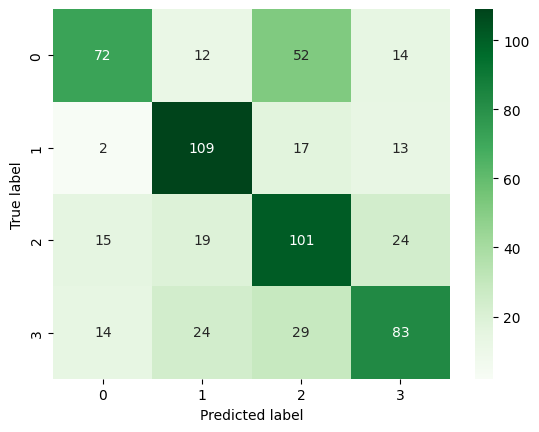

In [206]:
cm = confusion_matrix(np.argmax(y_depth_test, axis=1), predictions_classes)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
plt.ylabel('True label')
plt.xlabel('Predicted label')

**Affichez la loss et l'accuracy**

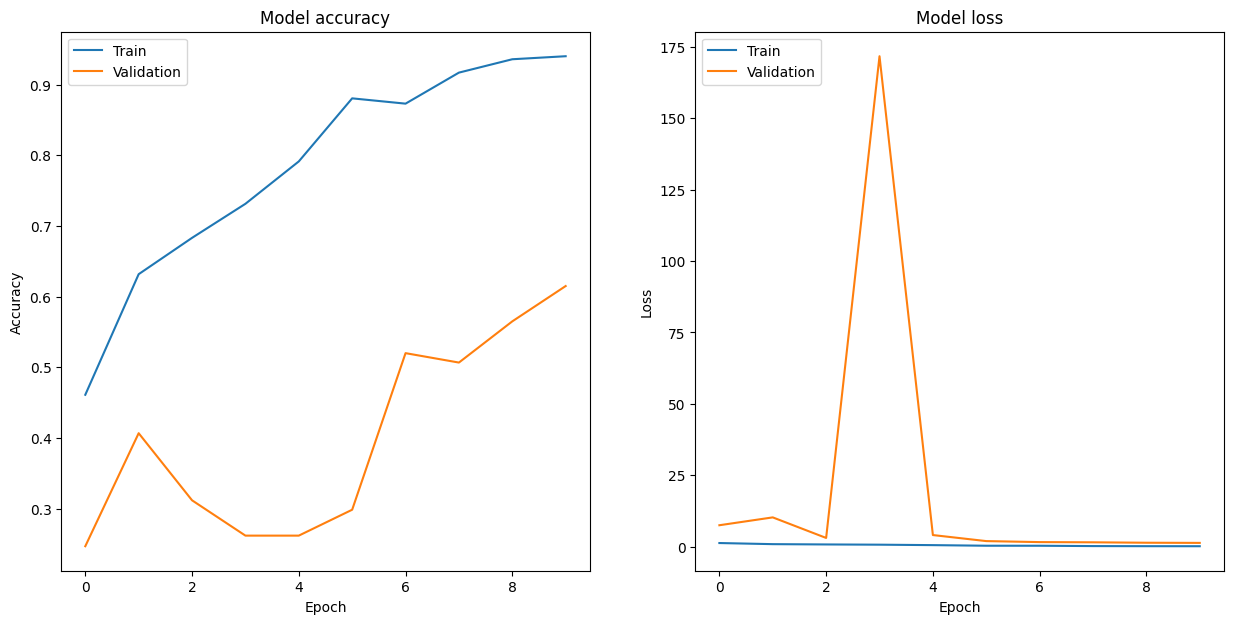

In [208]:
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

# Plot training & validation accuracy values
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Accuracy Plot')

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Loss Plot')

I have an outlier problem so I can't see the loss function correctly

**Ajuster le code ci-dessous afin qu'il affiche 5 images aléatoires RGB avec leur depth ainsi que la classe predite et réelle**

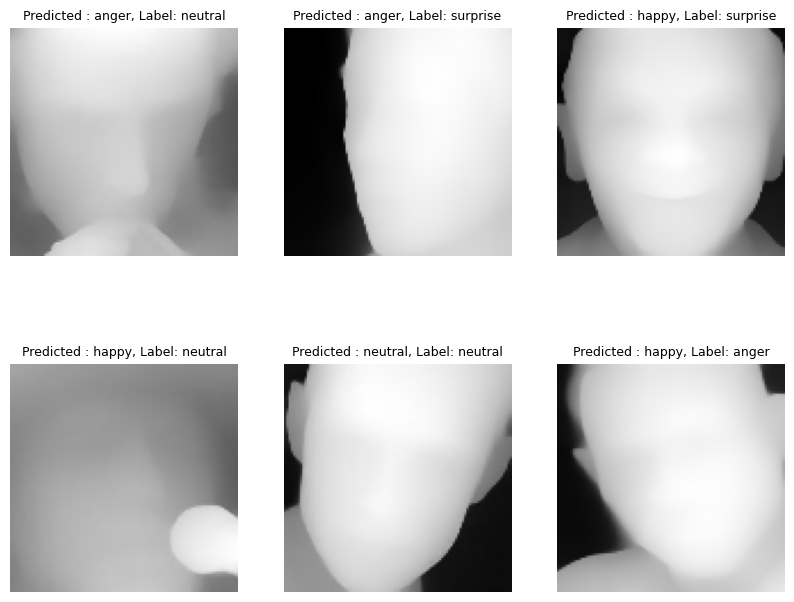

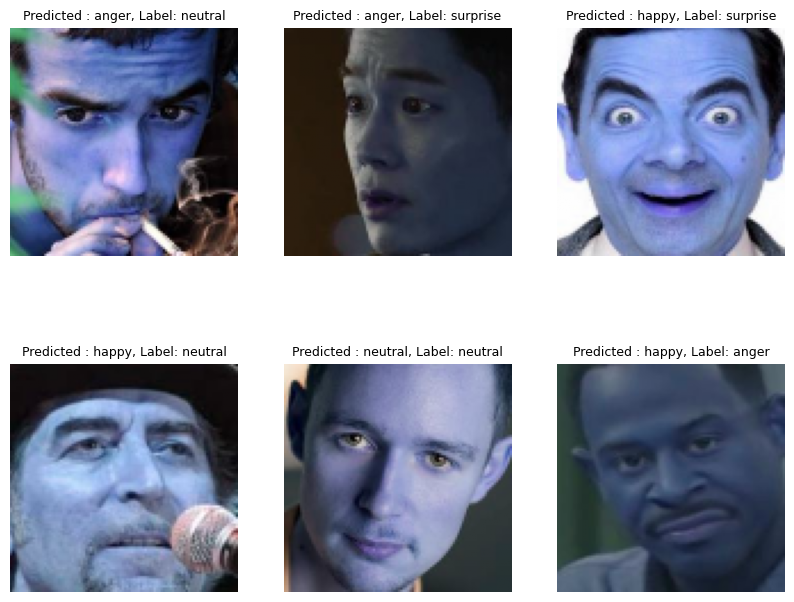

In [215]:
samples = np.random.choice(len(X_rgb_test), 6)

plt.figure(figsize=(10, 8))

for i, ind in enumerate(samples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_depth_test[ind])  
    plt.title(f"Predicted : {label_dict_inv[np.argmax(predictions[ind])]}, Label: {label_dict_inv[np.argmax(y_depth_test[ind])]}", fontsize=9)  
    plt.axis('off')  

plt.figure(figsize=(10, 8))

for i, ind in enumerate(samples):
    plt.subplot(2, 3, i + 1)
    plt.imshow(X_rgb_test[ind])  
    plt.title(f"Predicted : {label_dict_inv[np.argmax(predictions[ind])]}, Label: {label_dict_inv[np.argmax(y_rgb_test[ind])]}", fontsize=9)  
    plt.axis('off')  

**Implémentez une fonction show_confusion_matrix() qui :**

**- Fait des prédictions : Utilise le modèle pour prédire les catégories des images du jeu de test, qui n'a pas été vu par le modèle.**

**- Crée une matrice de confusion : Compare les prédictions avec les vraies étiquettes en utilisant une matrice de confusion. Les prédictions et les vraies étiquettes doivent être mappées aux noms des classes d'émotions.**

**- Affiche la matrice de confusion : Tracez la matrice de confusion sous forme de carte thermique (heatmap) annotée avec les vraies étiquettes sur l'axe des lignes et les étiquettes prédites sur l'axe des colonnes.**

**- Calcule la précision finale : Calculez et affichez la précision du modèle sur le jeu de test.**

In [218]:
def show_conf_mat(X_depth_test, X_rgb_test, y_depth_test, weights_path='./checkpoints/best_model.keras'):
    model = build_model()
    model.load_weights(weights_path)
    
    predictions = model.predict([X_rgb_test, X_depth_test])
    predictions_classes = np.argmax((predictions), axis=1)

    cm = confusion_matrix(np.argmax(y_depth_test, axis=1), predictions_classes)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

c:\Users\Jalil\Desktop\Ecole\M2TSI\tpenv\lib\site-packages\keras\src\saving\saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 974 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


19/19 ━━━━━━━━━━━━━━━━━━━━ 21s 893ms/step


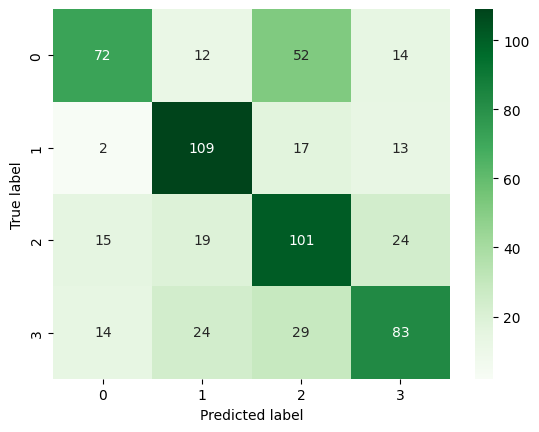

In [219]:
show_conf_mat(X_depth_test, X_rgb_test, y_depth_test)

**Créez deux fonctions : une fonction qui va créer un modèle pour traiter les images RGB et un autre qui va créer un modèle que pour les images depth. Evaluez les 3 modèles entre eux. Est ce que la fusion multimodale apporte plus de précision ?** 